<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-data" data-toc-modified-id="Load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Data-Preprocessing" data-toc-modified-id="Data-Preprocessing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Preprocessing</a></span><ul class="toc-item"><li><span><a href="#Normalisation" data-toc-modified-id="Normalisation-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Normalisation</a></span></li><li><span><a href="#Stemming" data-toc-modified-id="Stemming-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Stemming</a></span></li><li><span><a href="#TF-IDF" data-toc-modified-id="TF-IDF-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>TF-IDF</a></span></li></ul></li><li><span><a href="#Merging-Dataframes" data-toc-modified-id="Merging-Dataframes-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Merging Dataframes</a></span></li><li><span><a href="#Building-generators" data-toc-modified-id="Building-generators-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Building generators</a></span></li><li><span><a href="#Model-Creation" data-toc-modified-id="Model-Creation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model Creation</a></span><ul class="toc-item"><li><span><a href="#CNN" data-toc-modified-id="CNN-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>CNN</a></span></li><li><span><a href="#VGG16-(use-either-this-or-CNN)" data-toc-modified-id="VGG16-(use-either-this-or-CNN)-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>VGG16 (use either this or CNN)</a></span></li><li><span><a href="#LSTM" data-toc-modified-id="LSTM-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>LSTM</a></span></li><li><span><a href="#Combining-the-output" data-toc-modified-id="Combining-the-output-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Combining the output</a></span></li><li><span><a href="#Compilation" data-toc-modified-id="Compilation-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>Compilation</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-5.6"><span class="toc-item-num">5.6&nbsp;&nbsp;</span>Training</a></span></li></ul></li></ul></div>

In [26]:
import os
import numpy as np
import pandas as pd
import nltk
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import EnglishStemmer
from collections import defaultdict
import matplotlib.pyplot as plt

# Load data 

In [2]:
data = pd.read_csv("data/data.csv")
data = data[['uniq_id', 'description', 'categ', 'path', 'label']].set_index('uniq_id')

# We transform the categ into numeric values
data.categ = pd.Categorical(data.categ)
data['categ_number'] = np.int32(data.categ.cat.codes)

In [3]:
data.head()

,description,categ,path,label,categ_number
uniq_id,,,,,
4b500e244f11a45f5171bd3665413044,Key Features of Jacadi paris Baby Boy's Stripe...,Baby_Care,data/Train/Baby_Care/4b500e244f11a45f5171bd366...,Train,0
7ee2e665b7de2e1cc29e3c65bde0c318,Buy Mavi 237MBB Showpiece - 15 cm for Rs.129...,Home_Decor_And_Festive_Needs,data/Train/Home_Decor_And_Festive_Needs/7ee2e6...,Train,3
d21409978f5e404b53f89e444f7893fe,SF by Sonata 7991PP02 Ocean Digital Watch - F...,Watches,data/Train/Watches/d21409978f5e404b53f89e444f7...,Train,6
47d7792e50e69b048b1f17176f170141,Flipkart.com: Buy Beverly Hills Polo Club RED ...,Beauty_and_Personal_Care,data/Train/Beauty_and_Personal_Care/47d7792e50...,Train,1
ecb5bba9a5984d2b35b8ac3f56056c67,Flipkart.com: Buy Wild Stone Red And Juice Com...,Beauty_and_Personal_Care,data/Train/Beauty_and_Personal_Care/ecb5bba9a5...,Train,1


# Data Preprocessing

Here we will apply some function to the description for modeling later on

## Normalisation

In [4]:
data_text = data.reset_index()
data_text = data_text[['categ', 'description']]
# We take one line per category and sum the description
data_text = data_text.groupby('categ').sum()

In [5]:
# The goal here is to extract the frequences of the words
# And also to extract the frequences of unique words
tokenizer = nltk.RegexpTokenizer(r'\w+')

desc = defaultdict(list)

for i in data_text.index:
    desc[i] += tokenizer.tokenize(data_text.loc[i, 'description'].lower())

stats, freq = dict(), dict()

for k, v in zip(desc.keys(), desc.values()):
    freq[k] = fq = nltk.FreqDist(v)
    stats[k] = {'total': len(v), 'Unique': len(fq.keys())} 

df = pd.DataFrame.from_dict(stats, orient='index')

In [6]:
# First we get the freq of words on our dataset
freq_totale = nltk.Counter()
for k, v in zip(desc.keys(), desc.values()):
    freq_totale += freq[k]

# Here is our list of stop words
most_freq = { key:value for (key,value) in freq_totale.items() if value >= 100}.keys()

# Let's add the common stop words list of nltk
sw = set()
sw.update(most_freq)
sw.update(tuple(nltk.corpus.stopwords.words('english')))
sw.update(tuple(['!', '?', '.', ';', '"', "'", "#",
                 "&", "/", "-", "_", "'m",
                 "%", "*", "(", ")", "±3",
                 ",", "'s", '“', '”']))

tokenizer = nltk.RegexpTokenizer(r'\w+')

desc = defaultdict(list)

for i in data_text.index:
    token = tokenizer.tokenize(data_text.loc[i, 'description'].lower())
    desc[i] += [w for w in token if not w in list(sw)]

stats, freq = dict(), dict()

for k, v in zip(desc.keys(), desc.values()):
    freq[k] = fq = nltk.FreqDist(v)
    stats[k] = {'total': len(v), 'Unique': len(fq.keys())} 

df = pd.DataFrame.from_dict(stats, orient='index')

## Stemming

In [7]:
stemmer = EnglishStemmer()

tokenizer = nltk.RegexpTokenizer(r'\w+')

desc = defaultdict(list)

for i in data_text.index:
    token = tokenizer.tokenize(data_text.loc[i, 'description'].lower())
    desc[i] += [stemmer.stem(w) for w in token if not w in list(sw)]

stats, freq = dict(), dict()

for k, v in zip(desc.keys(), desc.values()):
    freq[k] = fq = nltk.FreqDist(v)
    stats[k] = {'total': len(v), 'Unique': len(fq.keys())}

df = pd.DataFrame.from_dict(stats, orient='index')

## TF-IDF

In [8]:
from sklearn.manifold import TSNE

data_tf = data.reset_index()[['uniq_id', 'categ', 'description']]

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

token_dict = defaultdict(list)

for i in range(0, len(data_tf)):
    lowers = data_tf.loc[i,'description'].lower()
    no_punctuation = lowers.translate(string.punctuation)
    token_dict[i] = no_punctuation

tfIdf = TfidfVectorizer(tokenizer=tokenize, stop_words=sw)
values = tfIdf.fit_transform(token_dict.values())

#Transform the results into a df
values = values.todense()
values = pd.DataFrame(values, index=data.index)
X_embedded = TSNE(n_components=1).fit_transform(values)
X_embedded_df = pd.DataFrame(X_embedded, index=data.index, columns=['tsne'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", '``', 'abov', 'adapt', 'ani', 'babi', 'batteri', 'becaus', 'befor', 'ceram', 'coffe', 'content', 'could', 'deliveri', 'detail', 'dimens', 'discount', 'doe', 'dure', 'easi', 'featur', 'genuin', 'guarante', 'materi', 'might', 'must', "n't", 'need', 'onc', 'onli', 'onlin', 'ourselv', 'packag', 'qualiti', 'replac', 'sale', 'sha', 'ship', 'showpiec', 'specif', 'themselv', 'veri', 'warranti', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


# Merging Dataframes

In [9]:
data_model = pd.merge(data, values,
                      left_index=True, right_index=True,
                      how='inner')
data_model = data_model.drop(columns=['description'])

# Building generators

Some of the code can be found here : https://github.com/sdcubber/Keras-Sequence-boilerplate/blob/master/Keras-Sequence.ipynb

In [10]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import math
import random
import tensorflow as tf
from tensorflow import keras
from keras.utils import Sequence
from PIL import Image

def load_image(im):
    return img_to_array(load_img(im, target_size=(224, 224), grayscale=False)) / 255.

class DataSequence(Sequence):
    """
    Keras Sequence object to train a model on larger-than-memory data.
    """
    def __init__(self, df, batch_size, mode='train'):
        self.df = df
        self.bsz = batch_size
        self.mode = mode

        # Take labels and a list of image locations in memory
        self.labels = self.df['categ_number'].values
        self.im_list = self.df['path'].tolist()
        #self.des = self.df['tsne'].tolist()
        self.des = self.df.iloc[:,4:]

    def __len__(self):
        return int(math.ceil(len(self.df) / float(self.bsz)))

    def on_epoch_end(self):
        # Shuffles indexes after each epoch if in training mode
        self.indexes = range(len(self.im_list))
        if self.mode == 'train':
            self.indexes = random.sample(self.indexes, k=len(self.indexes))

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return self.labels[idx * self.bsz: (idx + 1) * self.bsz]

    def get_batch_features(self, idx, type_="img"):
        # Fetch a batch of inputs
        if type_ == "img":
            ret = np.array([load_image(im) for im in self.im_list[idx * self.bsz: (1 + idx) * self.bsz]])
        else:
            #ret = np.array([tf for tf in self.des[idx * self.bsz: (1 + idx) * self.bsz]])
            ret = np.array([tf[1].values for tf in self.des[idx * self.bsz: (1 + idx) * self.bsz].iterrows()])
        return ret

    def __getitem__(self, idx):
        batch_x = self.get_batch_features(idx, type_="img")
        batch_x2 = self.get_batch_features(idx, type_="txt")
        batch_y = self.get_batch_labels(idx)
        return [batch_x, batch_x2], [batch_y]

Using TensorFlow backend.


# Model Creation

## CNN

In [11]:
from keras.models import Model
from keras.layers import Input, Conv2D, Dense, Dropout, MaxPool2D, Flatten, concatenate

# inputx = Input(shape=(224,224,3))
# x = MaxPool2D()(Conv2D(32, (3,3), activation='relu')(inputx))
# x = MaxPool2D()(Conv2D(32, (3,3), activation='relu')(x))
# x = MaxPool2D()(Conv2D(32, (3,3), activation='relu')(x))
# x = Flatten()(x)
# x = Dropout(0.2)(Dense(32, activation='relu')(x))
# x = Dense(32, activation='relu')(x)
# x = Dense(9, activation='relu')(x)

## VGG16 (use either this or CNN)

We'll here do some transfer learning with VGG16 <br/>
As the number of data that we have is low, we'll not retrain the Convolution part of the network

In [12]:
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

In [13]:
img_height, img_width = 224,224
inputx = Input(shape=(224, 224, 3), name='image')
vgg16 = VGG16(weights='imagenet', include_top=False,
              input_shape = (img_width, img_height, 3))(inputx)
x = Flatten()(vgg16) #Flatten the output of vgg16
x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)

## LSTM

For the first tries, we'll not add LSTM layers on the network

In [14]:
from keras.layers import LSTM

inputx2= Input(shape=(5718,), dtype='float32', name='tfidf_input')
x2 = Dense(512, activation='relu')(inputx2)
x2 = Dropout(0.15)(x2)
x2 = Dense(256, activation='relu')(x2)
x2 = Dense(64, activation='relu')(x2)

## Combining the output

In [15]:
combinedInput = concatenate([x, x2])

comb = Dense(9, activation='relu')(combinedInput)
comb = Dense(7, activation='softmax')(comb)

model = Model(inputs=[inputx, inputx2], outputs=comb)

## Compilation

In [16]:
from keras.optimizers import Adam

In [17]:
opt = Adam(lr=1e-5, clipnorm = 1.)
loss_fn  = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(loss=loss_fn, optimizer=opt,
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
tfidf_input (InputLayer)        (None, 5718)         0                                            
__________________________________________________________________________________________________
vgg16 (Model)                   (None, 7, 7, 512)    14714688    image[0][0]                      
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 512)          2928128     tfidf_input[0][0]                
____________________________________________________________________________________________

## Training

In [19]:
train = data_model[data_model['label'] == 'Train']
val = data_model[data_model['label'] == 'Validation']
test = data_model[data_model['label'] == 'Test']

In [20]:
seq = DataSequence(train,  batch_size=32)
valid = DataSequence(train,  batch_size=32, mode='Val')
history = model.fit_generator(seq, epochs=30, validation_data=valid, verbose=1)

Epoch 1/30
20/20 [==============================] - 27s 1s/step - loss: 1.9317 - accuracy: 0.0175 - val_loss: 1.8719 - val_accuracy: 0.0000e+00
Epoch 2/30
20/20 [==============================] - 14s 684ms/step - loss: 1.8397 - accuracy: 0.0000e+00 - val_loss: 1.7476 - val_accuracy: 0.0032
Epoch 3/30
20/20 [==============================] - 14s 688ms/step - loss: 1.6400 - accuracy: 0.0413 - val_loss: 1.4728 - val_accuracy: 0.1429
Epoch 4/30
20/20 [==============================] - 14s 697ms/step - loss: 1.4863 - accuracy: 0.1381 - val_loss: 1.4101 - val_accuracy: 0.1048
Epoch 5/30
20/20 [==============================] - 14s 686ms/step - loss: 1.4080 - accuracy: 0.1222 - val_loss: 1.3292 - val_accuracy: 0.1238
Epoch 6/30
20/20 [==============================] - 14s 693ms/step - loss: 1.3663 - accuracy: 0.1349 - val_loss: 1.2585 - val_accuracy: 0.1476
Epoch 7/30
20/20 [==============================] - 14s 694ms/step - loss: 1.3433 - accuracy: 0.1524 - val_loss: 1.2534 - val_accuracy: 0

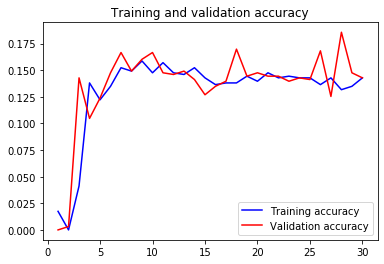

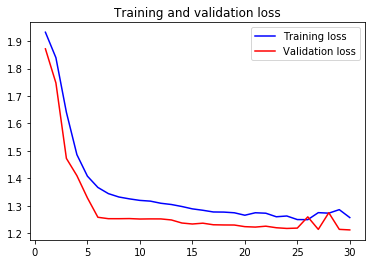

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

plt.figure()
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
# plt.savefig('Accuracy.jpg')

plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
# plt.savefig('Loss.jpg')